In [12]:
#!python -m spacy download nl_core_news_sm
!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=e2084d43df871017d738d54a0c1c7511da66fe2c2d9ddcd0dd5d355263bd9109
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [22]:
#Import necessary libraries
import pandas as pd
import spacy
from stop_words import get_stop_words

from gensim.models import nmf
from gensim.models import CoherenceModel,TfidfModel
from gensim import corpora
import re

In [23]:
data = pd.read_csv(r"data4ektha.csv")
data.head(2)

,Unnamed: 0,author_id.x,author_id.y,title.x,title.y,text.x,text.y,time.x,time.y
0,1,100064725607415,100054086851857,NaN,NaN,BUURTWONING | In Aalsmeer is sinds kort een Bu...,Dit is echt een schande. In deze tijd van woni...,2022-01-26 14:22:59,2022-02-02T05:59:11
1,2,100064725607415,1147377683,NaN,NaN,BUURTWONING | In Aalsmeer is sinds kort een Bu...,Waarom is Participe gewoon niet langer open. E...,2022-01-26 14:22:59,2022-02-02T01:40:04


In [24]:
# Load the spaCy Dutch model
nlp = spacy.load("nl_core_news_sm")

# Define a function to remove punctuation using spaCy remove
def remove_punctuation(text):
    doc = nlp(text)
    tokens_without_punct = [token.text for token in doc if not token.is_punct and token.text.strip()]  #checking punctuation and empty strings/spaces
    return ' '.join(tokens_without_punct)

#Function to convert all text to lower case and apply the punctuation function to remove punctuation
def prepocessing(texts):
    return texts.str.lower().apply(remove_punctuation)

# Preprocess all Dutch text data and labels
texts_final = list(prepocessing(data["text.y"]))

print("Text before preprocessing :", data["text.y"][:5])
print("Preprocessed text :" , texts_final[:5])

stop_words_dutch = get_stop_words('dutch')
print(len(stop_words_dutch))
print(stop_words_dutch)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Text before preprocessing : 0    Dit is echt een schande. In deze tijd van woni...
1    Waarom is Participe gewoon niet langer open. E...
2    Weer een woning uit het toch al beroerde besta...
3       in dat blok hebben wij gewoond. Geweldig huis!
4    Zonde om een woning hiervoor te gebruiken. Er ...
Name: text.y, dtype: object
Preprocessed text : ['dit is echt een schande in deze tijd van woningnood kunnen zulke mensen nou echt niet nadenken', 'waarom is participe gewoon niet langer open een maatschappelijk organisatie dat maar tot 12:30 open is maak dan gebruik van die ruimte mensen zoeken woningen en jullie gaan het gebruiken voor zogenaamd klaar staan voor bewoners', 'weer een woning uit het toch al beroerde bestand wat onnadenkend', 'in dat blok hebben wij gewoond geweldig huis', "zonde om een woning hiervoor te gebruiken er is al zo'n grote woningnood hier had weer iemand superblij mee gemaakt kunnen worden er zijn div plekken die kunnen worden gehuurd waar je een spreekuur kan 

In [25]:
# Split the documents into tokens
tokenized_documents_with_stopwords =  [doc.split(" ") for doc in texts_final]

# Create a dictionary from the tokenized documents
dictionary_with_stop_words = corpora.Dictionary(tokenized_documents_with_stopwords)

# Convert tokenized documents to a bag-of-words format using the dictionary
corpus_sw = [dictionary_with_stop_words.doc2bow(doc) for doc in tokenized_documents_with_stopwords]

# Create a TF-IDF model using the BoW corpus
tfidf_sw = TfidfModel(corpus_sw)

# Apply the TF-IDF model to the BoW corpus
corpus_tfidf_sw = list(tfidf_sw[corpus_sw])  # corpus_tfidf_sw contains the TF-IDF representation of each document

In [35]:
# Function to print topics extracted by NMF model
def print_nmf_topics(nmf_model, num_topics):
    topics = nmf_model.print_topics(num_topics=num_topics)  # Get the topics from the NMF model
    print("Topics with stop words:")

    # Compile regex pattern to extract words from the topics
    pattern = re.compile(r'"(.*?)"')

    # Process and print each topic
    for topic in topics:
      text = (topic[1].split("+"))
      matches = []
      for i in text:
          matches.append(pattern.findall(i)[0])
      print('_'.join(matches))

# Set the number of topics
num_topics = 2
# Ensure the correct number of topics is specified

# Run NMF model
try:
    nmf_model = nmf.Nmf(corpus_tfidf_sw, num_topics=num_topics, id2word=dictionary_with_stop_words, random_state=0, kappa=1)  # This line initializes and runs an NMF model on the TF-IDF corpus.

    # `num_topics` sets the number of topics to extract.
    # `id2word` is the dictionary mapping word IDs to words.
    # `random_state` ensures reproducibility.
    # `kappa` is a parameter that controls the regularization strength (default is 1).

    print_nmf_topics(nmf_model, num_topics)
except Exception as e:
    print(f"An error occurred: {e}")

Topics with stop words:
ik_je_de_in_maar_het_niet_en_er_aan
een_en_de_van_dat_het_is_op_niet_wat


In [37]:
# Initialize a list to store tokenized documents without stopwords
tokenized_documents_without_Stopwords = []

# Iterate through each document in `texts`
for doc in texts_final:
    # Split the document into words
    words = doc.split(" ")
    # Filter out stopwords and convert to lowercase
    filtered_words = [word for word in words if word.lower() not in stop_words_dutch]
    # Append filtered words to the list
    tokenized_documents_without_Stopwords.append(filtered_words)

# Create a dictionary from the tokenized documents without stopwords
dictionary_without_stop_words = corpora.Dictionary(tokenized_documents_without_Stopwords)

# Create a TF-IDF model using the dictionary
tfidf = TfidfModel(dictionary=dictionary_without_stop_words)

# Convert tokenized documents to a bag-of-words format using the dictionary
corpus = [dictionary_without_stop_words.doc2bow(doc) for doc in tokenized_documents_without_Stopwords]

# Apply the TF-IDF model to the BoW corpus
corpus_tfidf = list(tfidf[corpus])  # `corpus_tfidf` contains the TF-IDF representation of each document


In [50]:
# Set the number of topics
num_topics = 2

# Run NMF model
nmf_model = nmf.Nmf(corpus_tfidf, num_topics=num_topics, id2word=dictionary_without_stop_words, random_state=0, kappa=3)

print_nmf_topics(nmf_model, num_topics)


Topics with stop words:
groen_pensioen_8_stuk_voordat_sorry_initiatief_helpt_leon_moest
jullie_ontvangen_gefeliciteerd_woning_goed_nieuwe_wel_beter_wij_niks


In [54]:
# Initialize lists to store coherence scores
coherence_scores = []
coherence_scores_c_v = []
coherence_scores_uci = []
coherence_scores_nmpi = []

# Iterate over different numbers of topics
for num_topics in range(2, 10):
    # Train NMF model
    nmf_model = nmf.Nmf(corpus_tfidf, num_topics=num_topics, id2word=dictionary_without_stop_words, random_state=0, kappa=1)

    # Compute coherence scores using different coherence models

    # UMass coherence
    coherence_model = CoherenceModel(model=nmf_model, corpus=corpus_tfidf, dictionary=dictionary_without_stop_words, coherence='u_mass')
    coherence_score = coherence_model.get_coherence()


    # C_V coherence
    coherence_model_c_v = CoherenceModel(model=nmf_model, texts=tokenized_documents_without_Stopwords, dictionary=dictionary_without_stop_words, coherence='c_v')
    coherence_score_c_v = coherence_model_c_v.get_coherence()

    # C_UCI coherence
    coherence_model_uci = CoherenceModel(model=nmf_model, texts=tokenized_documents_without_Stopwords, dictionary=dictionary_without_stop_words, coherence='c_uci')
    coherence_score_uci = coherence_model_uci.get_coherence()


    # C_NPMI coherence
    coherence_model_nmpi = CoherenceModel(model=nmf_model, texts=tokenized_documents_without_Stopwords, dictionary=dictionary_without_stop_words, coherence='c_npmi')
    coherence_score_nmpi = coherence_model_nmpi.get_coherence()

    coherence_scores.append(round(coherence_score, 5))
    coherence_scores_c_v.append(round(coherence_score_c_v, 5))
    coherence_scores_uci.append(round(coherence_score_uci, 5))
    coherence_scores_nmpi.append(round(coherence_score_nmpi, 5))

In [73]:
from operator import itemgetter
# Get the number of topics with the highest coherence score for each metric
scores_umass = list(zip(range(2, 10), coherence_scores))
scores_c_v = list(zip(range(2, 10), coherence_scores_c_v))
scores_uci = list(zip(range(2, 10), coherence_scores_uci))
scores_npmi = list(zip(range(2, 10), coherence_scores_nmpi))

best_num_topics_umass = sorted(scores_umass, key=itemgetter(1), reverse=True)[0][0]
best_num_topics_c_v = sorted(scores_c_v, key=itemgetter(1), reverse=True)[0][0]
best_num_topics_uci = sorted(scores_uci, key=itemgetter(1), reverse=True)[0][0]
best_num_topics_npmi = sorted(scores_npmi, key=itemgetter(1), reverse=True)[0][0]

# Print or return the best number of topics for each coherence metric
print(f"Best number of topics based on 'u_mass' coherence: {best_num_topics_umass}")
print(f"Best number of topics based on 'c_v' coherence: {best_num_topics_c_v}")
print(f"Best number of topics based on 'c_uci' coherence: {best_num_topics_uci}")
print(f"Best number of topics based on 'c_npmi' coherence: {best_num_topics_npmi}")

Best number of topics based on 'u_mass' coherence: 2
Best number of topics based on 'c_v' coherence: 2
Best number of topics based on 'c_uci' coherence: 2
Best number of topics based on 'c_npmi' coherence: 2


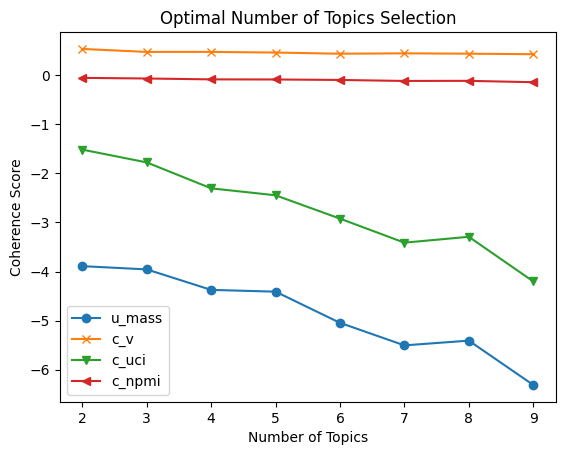

In [74]:
from matplotlib import pyplot as plt
import numpy as np

x = range(2, 10)
plt.plot(x, coherence_scores, marker='o',label='u_mass')
plt.plot(x, coherence_scores_c_v, marker='x',label="c_v")
plt.plot(x, coherence_scores_uci, marker='v',label='c_uci')
plt.plot(x, coherence_scores_nmpi, marker='<',label="c_npmi")
plt.legend()
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Selection")
plt.show()

/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:679: RuntimeWarning: divide by zero encountered in scalar divide
  eta = self._kappa / np.linalg.norm(self.A)
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:686: RuntimeWarning: invalid value encountered in multiply
  self._W -= eta * (WA - self.B)


[-2.6143660923979444, -2.616032130517187, -2.4611700577479505, -19.036216277263208]
[0.6570122519415047, 0.6570122519415049, 0.7310770339753777, 0.6600632602386999]
Best kappa value for u_mass: 1
Best kappa value for c_v: 1
Best kappa value for c_uci: 1
Best kappa value for c_npmi: 1


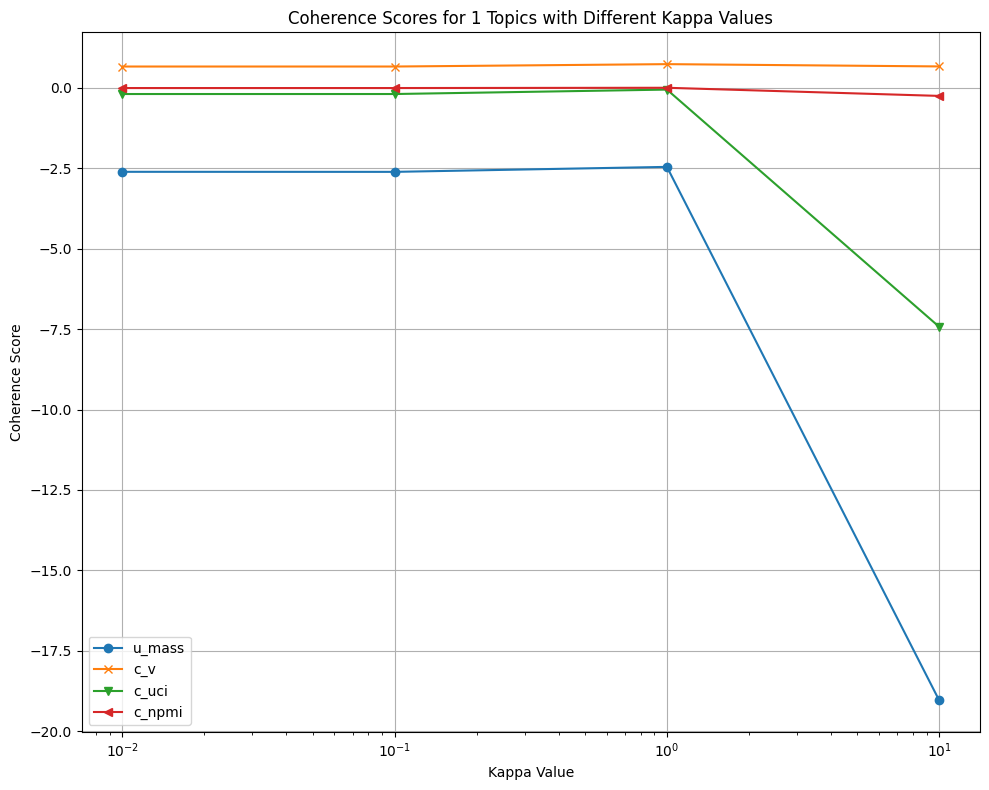

In [125]:
from gensim.models import nmf
from gensim.models.coherencemodel import CoherenceModel
from matplotlib import pyplot as plt
import numpy as np

# Initialize lists to store coherence scores
coherence_scores_umass = []
coherence_scores_c_v = []
coherence_scores_uci = []
coherence_scores_npmi = []

# Range of kappa values to experiment with
kappa_values = [0.01,0.1,1,10]

# Fixed number of topics
num_topics = 1

# Train NMF model for each kappa value
for kappa in kappa_values:
    # Train NMF model with current kappa value
    nmf_model = nmf.Nmf(corpus_tfidf, num_topics=num_topics, id2word=dictionary_without_stop_words, random_state=0, kappa=kappa)

    # Compute coherence scores using different coherence models
    coherence_model_umass = CoherenceModel(model=nmf_model, corpus=corpus_tfidf, dictionary=dictionary_without_stop_words, coherence='u_mass')
    coherence_score_umass = coherence_model_umass.get_coherence()
    coherence_scores_umass.append(coherence_score_umass)

    coherence_model_c_v = CoherenceModel(model=nmf_model, texts=tokenized_documents_without_Stopwords, dictionary=dictionary_without_stop_words, coherence='c_v')
    coherence_score_c_v = coherence_model_c_v.get_coherence()
    coherence_scores_c_v.append(coherence_score_c_v)

    coherence_model_uci = CoherenceModel(model=nmf_model, texts=tokenized_documents_without_Stopwords, dictionary=dictionary_without_stop_words, coherence='c_uci')
    coherence_score_uci = coherence_model_uci.get_coherence()
    coherence_scores_uci.append(coherence_score_uci)

    coherence_model_npmi = CoherenceModel(model=nmf_model, texts=tokenized_documents_without_Stopwords, dictionary=dictionary_without_stop_words, coherence='c_npmi')
    coherence_score_npmi = coherence_model_npmi.get_coherence()
    coherence_scores_npmi.append(coherence_score_npmi)

# Find the best kappa value based on maximum coherence score
best_kappa_umass = kappa_values[np.argmax(coherence_scores_umass)]
best_kappa_c_v = kappa_values[np.argmax(coherence_scores_c_v)]
best_kappa_uci = kappa_values[np.argmax(coherence_scores_uci)]
best_kappa_npmi = kappa_values[np.argmax(coherence_scores_npmi)]

print(coherence_scores_umass)
print(coherence_scores_c_v)
print(f"Best kappa value for u_mass: {best_kappa_umass}")
print(f"Best kappa value for c_v: {best_kappa_c_v}")
print(f"Best kappa value for c_uci: {best_kappa_uci}")
print(f"Best kappa value for c_npmi: {best_kappa_npmi}")

# Plotting with logarithmic x-axis
plt.figure(figsize=(10, 8))

# Plot coherence scores for each metric
plt.plot(kappa_values, coherence_scores_umass, marker='o', label='u_mass')
plt.plot(kappa_values, coherence_scores_c_v, marker='x', label='c_v')
plt.plot(kappa_values, coherence_scores_uci, marker='v', label='c_uci')
plt.plot(kappa_values, coherence_scores_npmi, marker='<', label='c_npmi')

# Adding labels and title
plt.xlabel("Kappa Value")
plt.ylabel("Coherence Score")
plt.title(f"Coherence Scores for {num_topics} Topics with Different Kappa Values")

plt.xticks(kappa_values, kappa_values)
plt.xscale("log")
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [166]:
# Set the number of topics
num_topics = 2

# Run NMF model
nmf_model = nmf.Nmf(corpus_tfidf, num_topics=num_topics, id2word=dictionary_without_stop_words, random_state=0, kappa=1)

print_nmf_topics(nmf_model, 5)


# nmf_model = nmf.Nmf(corpus_tfidf, num_topics=2, id2word=dictionary_without_stop_words, random_state=0, kappa=3)
# print_nmf_topics(nmf_model, 2)

# nmf_model = nmf.Nmf(corpus_tfidf, num_topics=2, id2word=dictionary_without_stop_words, random_state=0, kappa=0.01)
# print_nmf_topics(nmf_model, 2)

Topics with stop words:
we_huis_wel_krijgen_jaar_alleen_open_staat_onze_graag
jullie_niks_wij_wel_woning_goed_ontvangen_gefeliciteerd_nooit_jaar


Topic Distribution

In [167]:
doc_topic_assignments = []

for i, doc in enumerate(tokenized_documents_without_Stopwords):
    if len(doc) > 0:  # Check if the document is not empty
        doc_bow = dictionary_without_stop_words.doc2bow(doc)

        if doc_bow:  # Check if doc_bow is not empty
            topic_distribution = nmf_model[doc_bow]

            if topic_distribution:  # Check if topic_distribution is not empty
                assigned_topic = max(topic_distribution, key=lambda item: item[1])[0]
                doc_topic_assignments.append(assigned_topic)
            else:
                print(f"Warning: Document {i+1} has an empty topic distribution.")
        else:
            print(f"Warning: Document {i+1} is empty after preprocessing.")
    else:
        print(f"Warning: Document {i+1} is empty after preprocessing.")

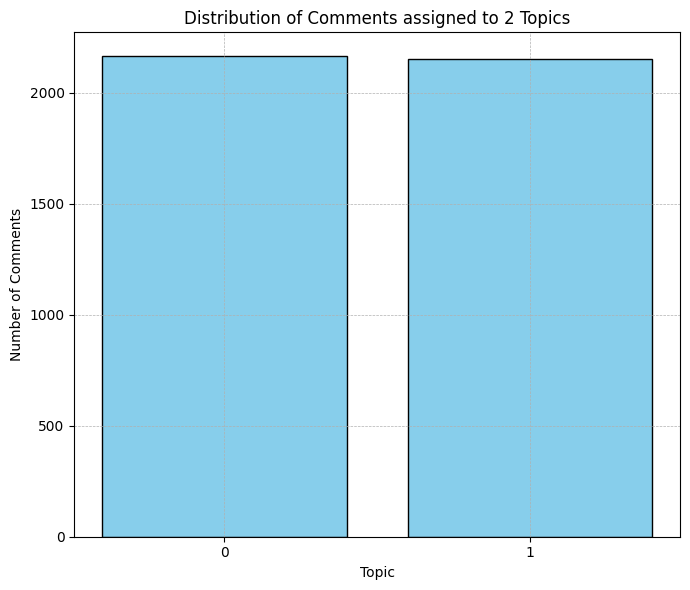

In [168]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences of each topic assignment
topic_counts = Counter(doc_topic_assignments)

# Extract topics and their corresponding counts
topics = list(topic_counts.keys())
counts = list(topic_counts.values())

# Plotting
plt.figure(figsize=(7, 6))
plt.bar(topics, counts, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Topic')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comments assigned to 2 Topics')

# Display the plot
plt.xticks(topics)  # Ensure all topics are displayed on x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines on y-axis
plt.tight_layout()
plt.show()